# Plot qPCR to characterize RNA expression and export efficiency with varying RNA cargo size (including qPCR on cells)

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Set output parameters

In [2]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_cargo_capacity"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [3]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

In [4]:
# Color palette
palette = ["#43adbf", "#969696"]

# Load data

## Load qPCR data

In [5]:
infile = "../preprocessed_data/qPCR_data/qPCR_cargo_capacity_Cq_supernatant.csv"

cq_raw_plate1 = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw_plate1.drop(columns_to_drop, axis=1, inplace=True)
cq_raw_plate1.set_index("Well", inplace=True)

print(cq_raw_plate1.shape)
cq_raw_plate1.head()

(93, 12)


,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Well,,,,,,,,,,,,
A01,SYBR,Cre,Unkn-01,33-1,NaN,25.650984,25.549075,0.186162,10612.576258,4.025821,11376.080518,1387.188998
A02,SYBR,Cre,Unkn-02,33-2,NaN,25.805092,25.395671,0.369626,9623.197202,3.983319,12704.004269,2829.864423
A03,SYBR,Cre,Unkn-03,33-3,NaN,25.599982,25.580803,0.308474,10961.918116,4.039887,11239.490279,2210.801079
A05,SYBR,Cre,Unkn-05,33-5,NaN,26.855537,26.431325,0.375239,4938.762938,3.693618,6583.986993,1469.354965
A06,SYBR,Cre,Unkn-06,33-6,NaN,28.296211,28.164196,0.132140,1978.316942,3.296296,2156.369410,180.808588


In [6]:
infile = "../preprocessed_data/qPCR_data/qPCR_cargo_capacity_Cq_cells.csv"

cq_raw_plate2 = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw_plate2.drop(columns_to_drop, axis=1, inplace=True)
cq_raw_plate2.set_index("Well", inplace=True)

print(cq_raw_plate2.shape)
cq_raw_plate2.head()

(86, 12)


,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Well,,,,,,,,,,,,
A01,SYBR,Cre,Unkn-01,33c-1,NaN,15.150337,14.945622,0.289510,1.389629e+07,7.142899,1.595721e+07,2.914584e+06
A03,SYBR,Cre,Unkn-03,33c-3,NaN,15.027149,15.003199,0.041982,1.502592e+07,7.176841,1.525961e+07,4.095160e+05
A04,SYBR,Cre,Unkn-04,33c-4,NaN,17.972607,18.076700,0.104396,2.318847e+06,6.365272,2.173830e+06,1.438588e+05
A05,SYBR,Cre,Unkn-05,33c-5,NaN,18.831978,18.331873,0.453800,1.344272e+06,6.128487,1.895833e+06,5.126744e+05
A06,SYBR,Cre,Unkn-06,33c-6,NaN,18.001818,17.948165,0.112189,2.276268e+06,6.357223,2.359116e+06,1.710753e+05


## Load metadata

In [7]:
# Load metadata (includes sample names)
infile = "../preprocessed_data/qPCR_data/qPCR_cargo_capacity_metadata.csv"
metadata = pd.read_csv(infile, index_col=0, header=0)
metadata = metadata.reset_index()
print(metadata.shape)
metadata.head()

(48, 7)


,Sample,Supernatant_or_Cell,Condition,Type,Replicate,transcript_length,LOD
0,33-1,Supernatant,Cre-MS2x12 +0 kb + EPN24-MCP,Exporter,1,2.0,4.599863
1,33-2,Supernatant,Cre-MS2x12 +0 kb + EPN24-MCP,Exporter,2,2.0,4.599863
2,33-3,Supernatant,Cre-MS2x12 +0 kb + EPN24-MCP,Exporter,3,2.0,4.599863
3,33-4,Supernatant,Cre-MS2x12 +3 kb + EPN24-MCP,Exporter,1,5.0,4.599863
4,33-5,Supernatant,Cre-MS2x12 +3 kb + EPN24-MCP,Exporter,2,5.0,4.599863


In [8]:
# Set order of conditions
condition_ordered = ["Cre-MS2x12 +0 kb + EPN24-MCP",
                     "Cre-MS2x12 +0 kb + stuffer",
                     "Cre-MS2x12 +0 kb",
                     "Cre-MS2x12 +3 kb + EPN24-MCP",
                     "Cre-MS2x12 +3 kb + stuffer",
                     "Cre-MS2x12 +3 kb",
                     "Cre-MS2x12 +5.4 kb + EPN24-MCP",
                     "Cre-MS2x12 +5.4 kb + stuffer",
                     "Cre-MS2x12 +5.4 kb",
                     "Cre-MS2x12 +7.8 kb + EPN24-MCP",
                     "Cre-MS2x12 +7.8 kb + stuffer",
                     "Cre-MS2x12 +7.8 kb",
                     "No DNA",
                     "WT"]

metadata["Condition"] = pd.Categorical(metadata["Condition"], categories=condition_ordered, ordered=True)

# Preprocess data

## Merge plates

In [9]:
# Combine

# Add column indicating plate
cq_raw_plate1["Plate"] = "Plate1"
cq_raw_plate2["Plate"] = "Plate2"

# Reset index so that well becomes a column
cq_raw_plate1.reset_index(inplace=True)
cq_raw_plate2.reset_index(inplace=True)

# Concatenate dataframes
cq_raw = pd.concat([cq_raw_plate1, cq_raw_plate2])
print(cq_raw.shape)
cq_raw.head()

(179, 14)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Plate
0,A01,SYBR,Cre,Unkn-01,33-1,NaN,25.650984,25.549075,0.186162,10612.576258,4.025821,11376.080518,1387.188998,Plate1
1,A02,SYBR,Cre,Unkn-02,33-2,NaN,25.805092,25.395671,0.369626,9623.197202,3.983319,12704.004269,2829.864423,Plate1
2,A03,SYBR,Cre,Unkn-03,33-3,NaN,25.599982,25.580803,0.308474,10961.918116,4.039887,11239.490279,2210.801079,Plate1
3,A05,SYBR,Cre,Unkn-05,33-5,NaN,26.855537,26.431325,0.375239,4938.762938,3.693618,6583.986993,1469.354965,Plate1
4,A06,SYBR,Cre,Unkn-06,33-6,NaN,28.296211,28.164196,0.132140,1978.316942,3.296296,2156.369410,180.808588,Plate1


## Map metadata to individual replicates

In [10]:
cq_raw = cq_raw.reset_index(drop=True).set_index("Sample")
cq_raw = cq_raw.join(metadata.set_index("Sample"))
cq_raw = cq_raw.reset_index(drop=False)

cq_raw.head()

,Sample,Well,Fluor,Target,Content,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Plate,Supernatant_or_Cell,Condition,Type,Replicate,transcript_length,LOD
0,33-1,A01,SYBR,Cre,Unkn-01,NaN,25.650984,25.549075,0.186162,10612.576258,4.025821,11376.080518,1387.188998,Plate1,Supernatant,Cre-MS2x12 +0 kb + EPN24-MCP,Exporter,1.0,2.0,4.599863
1,33-1,B01,SYBR,Cre,Unkn-01,NaN,25.662034,25.549075,0.186162,10538.369959,4.022773,11376.080518,1387.188998,Plate1,Supernatant,Cre-MS2x12 +0 kb + EPN24-MCP,Exporter,1.0,2.0,4.599863
2,33-1,C01,SYBR,Cre,Unkn-01,NaN,25.334208,25.549075,0.186162,12977.295337,4.113184,11376.080518,1387.188998,Plate1,Supernatant,Cre-MS2x12 +0 kb + EPN24-MCP,Exporter,1.0,2.0,4.599863
3,33-10,A10,SYBR,Cre,Unkn-10,NaN,30.175856,29.616290,0.492200,599.667313,2.777910,882.153093,250.954863,Plate1,Supernatant,Cre-MS2x12 +7.8 kb + EPN24-MCP,Exporter,1.0,9.8,4.599863
4,33-10,B10,SYBR,Cre,Unkn-10,NaN,29.422675,29.616290,0.492200,967.452424,2.985630,882.153093,250.954863,Plate1,Supernatant,Cre-MS2x12 +7.8 kb + EPN24-MCP,Exporter,1.0,9.8,4.599863


## Censor values below lower limit of quantification (LLoQ)

In [11]:
cq_raw["SQ censored"] = cq_raw["Starting Quantity (SQ)"]

# Set values below limit of detection to limit of detection
selector = cq_raw["SQ censored"] < cq_raw["LOD"]
cq_raw.loc[selector, "SQ censored"] = cq_raw.loc[selector, "LOD"]

# Set wells without detection to limit of detection
selector = cq_raw["SQ censored"].isna()
cq_raw.loc[selector, "SQ censored"] = cq_raw.loc[selector, "LOD"]

## Summarize technical replicates

In [12]:
groups = cq_raw.groupby(["Sample"])  # group samples by origin

summary_tech = pd.DataFrame()

summary_tech["mean SQ"] = groups["Starting Quantity (SQ)"].mean()  # Calculate mean over replicates
summary_tech["std SQ"] = groups["Starting Quantity (SQ)"].std()  # Calculate std over replicates

summary_tech["mean SQ censored"] = groups["SQ censored"].mean()  # Calculate mean over replicates
summary_tech["std SQ censored"] = groups["SQ censored"].std()  # Calculate mean over replicates

summary_tech

,mean SQ,std SQ,mean SQ censored,std SQ censored
Sample,,,,
33-1,1.137608e+04,1387.188998,1.137608e+04,1387.188998
33-10,8.821531e+02,250.954863,8.821531e+02,250.954863
33-11,1.861820e+02,51.812363,1.861820e+02,51.812363
33-12,1.022375e+03,151.312309,1.022375e+03,151.312309
33-13,3.535907e+01,9.164415,3.535907e+01,9.164415
...,...,...,...,...
33c-6,2.359116e+06,171075.297260,2.359116e+06,171075.297260
33c-7,5.680831e+05,51557.522837,5.680831e+05,51557.522837
33c-8,6.850979e+05,60817.657806,6.850979e+05,60817.657806


## Map metadata to summary of technical replicates

In [13]:
summary_tech = summary_tech.join(metadata.set_index("Sample"))

summary_tech.head()

,mean SQ,std SQ,mean SQ censored,std SQ censored,Supernatant_or_Cell,Condition,Type,Replicate,transcript_length,LOD
Sample,,,,,,,,,,
33-1,11376.080518,1387.188998,11376.080518,1387.188998,Supernatant,Cre-MS2x12 +0 kb + EPN24-MCP,Exporter,1.0,2.0,4.599863
33-10,882.153093,250.954863,882.153093,250.954863,Supernatant,Cre-MS2x12 +7.8 kb + EPN24-MCP,Exporter,1.0,9.8,4.599863
33-11,186.182046,51.812363,186.182046,51.812363,Supernatant,Cre-MS2x12 +7.8 kb + EPN24-MCP,Exporter,2.0,9.8,4.599863
33-12,1022.375247,151.312309,1022.375247,151.312309,Supernatant,Cre-MS2x12 +7.8 kb + EPN24-MCP,Exporter,3.0,9.8,4.599863
33-13,35.359069,9.164415,35.359069,9.164415,Supernatant,Cre-MS2x12 +0 kb,No exporter,1.0,2.0,4.599863


## Summarize biological replicates

In [14]:
groups = summary_tech.groupby(["Supernatant_or_Cell", "Condition"])  # group samples by origin

summary = pd.DataFrame()

summary["mean SQ"] = groups["mean SQ"].mean()  # Calculate mean over biological replicates
summary["std SQ"] = groups["std SQ"].mean()  # Calculate std over biological replicates

summary["mean SQ censored"] = groups["mean SQ censored"].mean()  # Calculate mean over biological replicates
summary["std SQ censored"] = groups["std SQ censored"].mean()  # Calculate std over biological replicates

summary["transcript_length"] = groups["transcript_length"].mean()

summary

mean SQ        std SQ  mean SQ censored  std SQ censored  transcript_length
Supernatant_or_Cell Condition                                                                                                       
Cell                Cre-MS2x12 +0 kb + EPN24-MCP    1.511360e+07  1.714684e+06      1.511360e+07     1.714684e+06                2.0
                    Cre-MS2x12 +0 kb + stuffer      2.938950e+06  6.538889e+05      2.938950e+06     6.538889e+05                2.0
                    Cre-MS2x12 +0 kb                3.725248e+06  6.089407e+05      3.725248e+06     6.089407e+05                2.0
                    Cre-MS2x12 +3 kb + EPN24-MCP    2.142926e+06  2.758695e+05      2.142926e+06     2.758695e+05                5.0
                    Cre-MS2x12 +3 kb + stuffer      2.224526e+06  4.092168e+05      2.224526e+06     4.092168e+05                5.0
                    Cre-MS2x12 +3 kb                3.803183e+06  4.342922e+05      3.803183e+06     4.342922e+05                5.0
                    Cre-MS2x12 +5.4 kb + EPN24-MCP  6.854252e+05  1.282780e+05      6.854252e+05     1.282780e+05                7.4
                    Cre-MS2x12 +5.4 kb + stuffer    5.357730e+05  1.219825e+05      5.357730e+05     1.219825e+05                7.4
                    Cre-MS2x12 +5.4 kb              1.182536e+06  2.489078e+04      1.182536e+06     2.489078e+04                7.4
                    Cre-MS2x12 +7.8 kb + EPN24-MCP  5.384805e+05  9.368521e+04      5.384805e+05     9.368521e+04                9.8
                    Cre-MS2x12 +7.8 kb + stuffer    4.123499e+05  3.523193e+04      4.123499e+05     3.523193e+04                9.8
                    Cre-MS2x12 +7.8 kb              7.342480e+05  1.372481e+05      7.342480e+05     1.372481e+05                9.8
                    No DNA                          2.655554e+01  1.783573e+01      2.758584e+01     8.917865e+00                NaN
                    WT                              7.657827e+00  3.874915e+00      7.644975e+00     1.875661e+00                NaN
Supernatant         Cre-MS2x12 +0 kb + EPN24-MCP    1.177319e+04  2.142618e+03      1.177319e+04     2.142618e+03                2.0
                    Cre-MS2x12 +0 kb + stuffer      1.557835e+01  6.872326e+00      1.557835e+01     6.872326e+00                2.0
                    Cre-MS2x12 +0 kb                3.535907e+01  9.164415e+00      3.535907e+01     9.164415e+00                2.0
                    Cre-MS2x12 +3 kb + EPN24-MCP    4.315262e+03  6.408095e+02      4.315262e+03     6.408095e+02                5.0
                    Cre-MS2x12 +3 kb + stuffer      4.348737e+01  2.030185e+01      4.348737e+01     2.030185e+01                5.0
                    Cre-MS2x12 +3 kb                4.681573e+01  1.606477e+01      4.681573e+01     1.606477e+01                5.0
                    Cre-MS2x12 +5.4 kb + EPN24-MCP  1.513607e+03  3.439864e+02      1.513607e+03     3.439864e+02                7.4
                    Cre-MS2x12 +5.4 kb + stuffer    6.271666e+01  1.432427e+01      6.271666e+01     1.432427e+01                7.4
                    Cre-MS2x12 +5.4 kb              2.298663e+01  9.937241e+00      2.298663e+01     9.937241e+00                7.4
                    Cre-MS2x12 +7.8 kb + EPN24-MCP  6.969035e+02  1.513598e+02      6.969035e+02     1.513598e+02                9.8
                    Cre-MS2x12 +7.8 kb + stuffer    5.554002e+01  6.953599e+00      5.554002e+01     6.953599e+00                9.8
                    Cre-MS2x12 +7.8 kb              8.856374e+01  2.863687e+01      8.856374e+01     2.863687e+01                9.8
                    No DNA                          3.051710e+01  8.322377e+00      3.051710e+01     8.322377e+00                NaN
                    WT                              5.448945e+01  7.946690e+00      5.448945e+01     7.946690e+00                NaN

## Calculate relative RNA abundance (normalized relative to reference)

In [15]:
# Calculate RNA abundance normalized (relative to reference)

ref = summary.loc["Supernatant", "No DNA"]["mean SQ censored"]

summary["mean SQ censored norm"] = summary["mean SQ censored"] / ref
summary["std SQ censored norm"] = summary["std SQ censored"] / ref

summary

mean SQ        std SQ  mean SQ censored  std SQ censored  transcript_length  mean SQ censored norm  std SQ censored norm
Supernatant_or_Cell Condition                                                                                                                                                    
Cell                Cre-MS2x12 +0 kb + EPN24-MCP    1.511360e+07  1.714684e+06      1.511360e+07     1.714684e+06                2.0          495250.292508          56187.642789
                    Cre-MS2x12 +0 kb + stuffer      2.938950e+06  6.538889e+05      2.938950e+06     6.538889e+05                2.0           96305.040074          21426.970418
                    Cre-MS2x12 +0 kb                3.725248e+06  6.089407e+05      3.725248e+06     6.089407e+05                2.0          122070.849060          19954.085234
                    Cre-MS2x12 +3 kb + EPN24-MCP    2.142926e+06  2.758695e+05      2.142926e+06     2.758695e+05                5.0           70220.514592           9039.834146
                    Cre-MS2x12 +3 kb + stuffer      2.224526e+06  4.092168e+05      2.224526e+06     4.092168e+05                5.0           72894.414051          13409.427999
                    Cre-MS2x12 +3 kb                3.803183e+06  4.342922e+05      3.803183e+06     4.342922e+05                5.0          124624.674784          14231.110592
                    Cre-MS2x12 +5.4 kb + EPN24-MCP  6.854252e+05  1.282780e+05      6.854252e+05     1.282780e+05                7.4           22460.367597           4203.481118
                    Cre-MS2x12 +5.4 kb + stuffer    5.357730e+05  1.219825e+05      5.357730e+05     1.219825e+05                7.4           17556.488081           3997.185386
                    Cre-MS2x12 +5.4 kb              1.182536e+06  2.489078e+04      1.182536e+06     2.489078e+04                7.4           38749.965631            815.633976
                    Cre-MS2x12 +7.8 kb + EPN24-MCP  5.384805e+05  9.368521e+04      5.384805e+05     9.368521e+04                9.8           17645.208144           3069.925436
                    Cre-MS2x12 +7.8 kb + stuffer    4.123499e+05  3.523193e+04      4.123499e+05     3.523193e+04                9.8           13512.093381           1154.498193
                    Cre-MS2x12 +7.8 kb              7.342480e+05  1.372481e+05      7.342480e+05     1.372481e+05                9.8           24060.217408           4497.415132
                    No DNA                          2.655554e+01  1.783573e+01      2.758584e+01     8.917865e+00                NaN               0.903947              0.292225
                    WT                              7.657827e+00  3.874915e+00      7.644975e+00     1.875661e+00                NaN               0.250515              0.061463
Supernatant         Cre-MS2x12 +0 kb + EPN24-MCP    1.177319e+04  2.142618e+03      1.177319e+04     2.142618e+03                2.0             385.790037             70.210421
                    Cre-MS2x12 +0 kb + stuffer      1.557835e+01  6.872326e+00      1.557835e+01     6.872326e+00                2.0               0.510479              0.225196
                    Cre-MS2x12 +0 kb                3.535907e+01  9.164415e+00      3.535907e+01     9.164415e+00                2.0               1.158664              0.300304
                    Cre-MS2x12 +3 kb + EPN24-MCP    4.315262e+03  6.408095e+02      4.315262e+03     6.408095e+02                5.0             141.404752             20.998376
                    Cre-MS2x12 +3 kb + stuffer      4.348737e+01  2.030185e+01      4.348737e+01     2.030185e+01                5.0               1.425017              0.665262
                    Cre-MS2x12 +3 kb                4.681573e+01  1.606477e+01      4.681573e+01     1.606477e+01                5.0               1.534082              0.526419
                    Cre-MS2x12 +5.4 kb + EPN24-MCP  1.513607e+03  3.439864e+02      1.513607e+03     3.439864e+02                7.4         

In [16]:
# Calculate for technical replicates and summary of technical replicates

cq_raw["mean SQ censored norm"] = cq_raw["SQ censored"] / ref
cq_raw["std SQ censored norm"] = cq_raw["SQ Std. Dev"] / ref

summary_tech["mean SQ censored norm"] = summary_tech["mean SQ censored"] / ref
summary_tech["std SQ censored norm"] = summary_tech["std SQ censored"] / ref

summary_tech

,mean SQ,std SQ,mean SQ censored,std SQ censored,Supernatant_or_Cell,Condition,Type,Replicate,transcript_length,LOD,mean SQ censored norm,std SQ censored norm
Sample,,,,,,,,,,,,
33-1,1.137608e+04,1387.188998,1.137608e+04,1387.188998,Supernatant,Cre-MS2x12 +0 kb + EPN24-MCP,Exporter,1.0,2.0,4.599863,372.777293,45.456127
33-10,8.821531e+02,250.954863,8.821531e+02,250.954863,Supernatant,Cre-MS2x12 +7.8 kb + EPN24-MCP,Exporter,1.0,9.8,4.599863,28.906849,8.223419
33-11,1.861820e+02,51.812363,1.861820e+02,51.812363,Supernatant,Cre-MS2x12 +7.8 kb + EPN24-MCP,Exporter,2.0,9.8,4.599863,6.100910,1.697814
33-12,1.022375e+03,151.312309,1.022375e+03,151.312309,Supernatant,Cre-MS2x12 +7.8 kb + EPN24-MCP,Exporter,3.0,9.8,4.599863,33.501721,4.958280
33-13,3.535907e+01,9.164415,3.535907e+01,9.164415,Supernatant,Cre-MS2x12 +0 kb,No exporter,1.0,2.0,4.599863,1.158664,0.300304
...,...,...,...,...,...,...,...,...,...,...,...,...
33c-6,2.359116e+06,171075.297260,2.359116e+06,171075.297260,Cell,Cre-MS2x12 +3 kb + EPN24-MCP,Exporter,3.0,5.0,5.713248,77304.730591,5605.883860
33c-7,5.680831e+05,51557.522837,5.680831e+05,51557.522837,Cell,Cre-MS2x12 +5.4 kb + EPN24-MCP,Exporter,1.0,7.4,5.713248,18615.239843,1689.463586
33c-8,6.850979e+05,60817.657806,6.850979e+05,60817.657806,Cell,Cre-MS2x12 +5.4 kb + EPN24-MCP,Exporter,2.0,7.4,5.713248,22449.642940,1992.904480


## Calculate supernatant abundance normalized by cellular abundance

In [17]:
summary_export_cell_norm = pd.DataFrame()

# Calculate abundance in supernatant normalized by abundance in cells (normalized export)
summary_export_cell_norm["mean SQ censored norm sup over cells"] = summary.loc["Supernatant"]["mean SQ censored norm"]  / summary.loc["Cell"]["mean SQ censored norm"]

# Calculate standard deviation of normalized export by error propagation
# Assume zero covariance
summary_export_cell_norm["std SQ censored norm sup over cells"] = (summary.loc["Supernatant"]["mean SQ censored norm"]  / summary.loc["Cell"]["mean SQ censored norm"]) * np.sqrt((summary.loc["Supernatant"]["std SQ censored norm"] / summary.loc["Supernatant"]["mean SQ censored norm"])**2 + (summary.loc["Cell"]["std SQ censored norm"] / summary.loc["Cell"]["mean SQ censored norm"])**2)

# Calculate normalized export relative to smallest cargo
ref = summary_export_cell_norm.loc["Cre-MS2x12 +0 kb + EPN24-MCP", "mean SQ censored norm sup over cells"]
summary_export_cell_norm["mean SQ censored norm sup over cells rel"] = summary_export_cell_norm["mean SQ censored norm sup over cells"] / ref
summary_export_cell_norm["std SQ censored norm sup over cells rel"] = summary_export_cell_norm["std SQ censored norm sup over cells"] / ref

summary_export_cell_norm["transcript_length"] = summary.loc["Cell"]["transcript_length"]

summary_export_cell_norm

,mean SQ censored norm sup over cells,std SQ censored norm sup over cells,mean SQ censored norm sup over cells rel,std SQ censored norm sup over cells rel,transcript_length
Condition,,,,,
Cre-MS2x12 +0 kb + EPN24-MCP,0.000779,0.000167,1.000000,0.214458,2.0
Cre-MS2x12 +0 kb + stuffer,0.000005,0.000003,0.006805,0.003362,2.0
Cre-MS2x12 +0 kb,0.000009,0.000003,0.012185,0.003734,2.0
Cre-MS2x12 +3 kb + EPN24-MCP,0.002014,0.000396,2.585078,0.508048,5.0
Cre-MS2x12 +3 kb + stuffer,0.000020,0.000010,0.025096,0.012593,5.0
Cre-MS2x12 +3 kb,0.000012,0.000004,0.015802,0.005715,5.0
Cre-MS2x12 +5.4 kb + EPN24-MCP,0.002208,0.000650,2.834829,0.834586,7.4
Cre-MS2x12 +5.4 kb + stuffer,0.000117,0.000038,0.150271,0.048461,7.4
Cre-MS2x12 +5.4 kb,0.000019,0.000008,0.024954,0.010800,7.4


# Visualize RNA abundance in supernatant versus length

In [18]:
index_ordered = ["Cre-MS2x12 +0 kb + EPN24-MCP",
                 "Cre-MS2x12 +3 kb + EPN24-MCP",
                 "Cre-MS2x12 +5.4 kb + EPN24-MCP", 
                 "Cre-MS2x12 +7.8 kb + EPN24-MCP"]

data = summary.loc["Supernatant"].loc[index_ordered].reset_index()

data

,Condition,mean SQ,std SQ,mean SQ censored,std SQ censored,transcript_length,mean SQ censored norm,std SQ censored norm
0,Cre-MS2x12 +0 kb + EPN24-MCP,11773.191689,2142.618167,11773.191689,2142.618167,2.0,385.790037,70.210421
1,Cre-MS2x12 +3 kb + EPN24-MCP,4315.262418,640.809454,4315.262418,640.809454,5.0,141.404752,20.998376
2,Cre-MS2x12 +5.4 kb + EPN24-MCP,1513.607032,343.986435,1513.607032,343.986435,7.4,49.598658,11.271925
3,Cre-MS2x12 +7.8 kb + EPN24-MCP,696.903462,151.359845,696.903462,151.359845,9.8,22.836493,4.959838


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


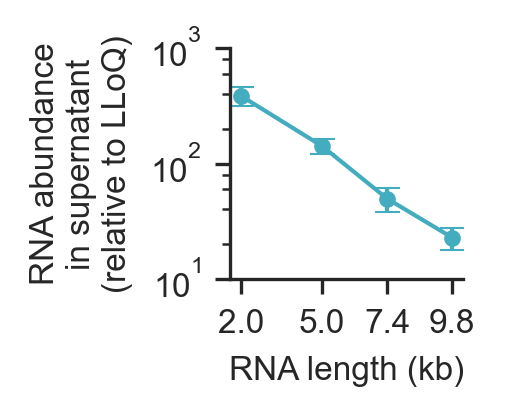

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(1, 1))

ax.set_yscale("log")

x = data["transcript_length"]
y = data["mean SQ censored norm"]
yerr = data["std SQ censored norm"]

ax.errorbar(x=x,
            y=y,
            yerr=yerr,
            color=palette[0],
            marker=".",
            capsize=3,
            capthick=0.5,
            lw=1,
            label="EPN24-MCP")

ax.set_ylim(1e1, 1e3)

ax.set_xticks([2, 5, 7.4, 9.8])

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xlabel("RNA length (kb)")
ax.set_ylabel("RNA abundance\nin supernatant\n(relative to LLoQ)")

sns.despine()

save_figure(fig, "RNA_in_supernatant_vs_cargo_length")

# Visualize RNA abundance in cells versus length

In [20]:
index_ordered = ["Cre-MS2x12 +0 kb + EPN24-MCP",
                 "Cre-MS2x12 +3 kb + EPN24-MCP",
                 "Cre-MS2x12 +5.4 kb + EPN24-MCP", 
                 "Cre-MS2x12 +7.8 kb + EPN24-MCP"]

data = summary.loc["Cell"].loc[index_ordered].reset_index()

data

,Condition,mean SQ,std SQ,mean SQ censored,std SQ censored,transcript_length,mean SQ censored norm,std SQ censored norm
0,Cre-MS2x12 +0 kb + EPN24-MCP,1.511360e+07,1.714684e+06,1.511360e+07,1.714684e+06,2.0,495250.292508,56187.642789
1,Cre-MS2x12 +3 kb + EPN24-MCP,2.142926e+06,2.758695e+05,2.142926e+06,2.758695e+05,5.0,70220.514592,9039.834146
2,Cre-MS2x12 +5.4 kb + EPN24-MCP,6.854252e+05,1.282780e+05,6.854252e+05,1.282780e+05,7.4,22460.367597,4203.481118
3,Cre-MS2x12 +7.8 kb + EPN24-MCP,5.384805e+05,9.368521e+04,5.384805e+05,9.368521e+04,9.8,17645.208144,3069.925436


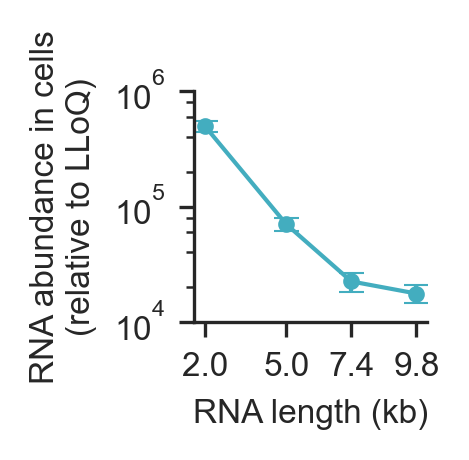

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(1, 1))

ax.set_yscale("log")

x = data["transcript_length"]
y = data["mean SQ censored norm"]
yerr = data["std SQ censored norm"]

ax.errorbar(x=x,
            y=y,
            yerr=yerr,
            color=palette[0],
            marker=".",
            capsize=3,
            capthick=0.5,
            lw=1,
            label="EPN24-MCP")

ax.set_ylim(1e4, 1e6)

ax.set_xticks([2, 5, 7.4, 9.8])

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())

ax.set_xlabel("RNA length (kb)")
ax.set_ylabel("RNA abundance in cells\n(relative to LLoQ)")

sns.despine()

save_figure(fig, "RNA_in_cells_vs_cargo_length")

# Visualize normalized export (RNA abundance in supernatant normalized by cells) versus length

In [22]:
index_ordered = ["Cre-MS2x12 +0 kb + EPN24-MCP",
                 "Cre-MS2x12 +3 kb + EPN24-MCP",
                 "Cre-MS2x12 +5.4 kb + EPN24-MCP", 
                 "Cre-MS2x12 +7.8 kb + EPN24-MCP"]

data = summary_export_cell_norm.loc[index_ordered].reset_index()

data

,Condition,mean SQ censored norm sup over cells,std SQ censored norm sup over cells,mean SQ censored norm sup over cells rel,std SQ censored norm sup over cells rel,transcript_length
0,Cre-MS2x12 +0 kb + EPN24-MCP,0.000779,0.000167,1.000000,0.214458,2.0
1,Cre-MS2x12 +3 kb + EPN24-MCP,0.002014,0.000396,2.585078,0.508048,5.0
2,Cre-MS2x12 +5.4 kb + EPN24-MCP,0.002208,0.000650,2.834829,0.834586,7.4
3,Cre-MS2x12 +7.8 kb + EPN24-MCP,0.001294,0.000360,1.661408,0.462339,9.8


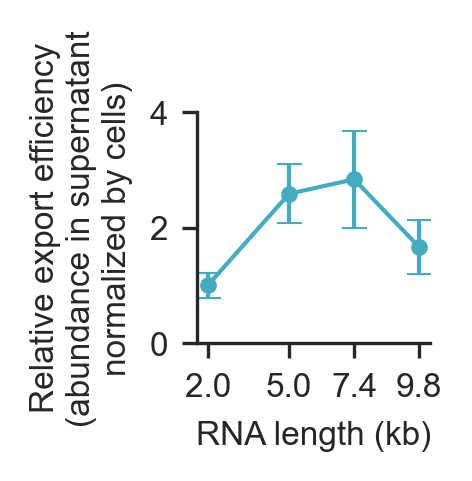

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(1, 1))

x = data["transcript_length"]
y = data["mean SQ censored norm sup over cells rel"]
yerr = data["std SQ censored norm sup over cells rel"]

ax.errorbar(x=x,
            y=y,
            yerr=yerr,
            color=palette[0],
            marker=".",
            capsize=3,
            capthick=0.5,
            lw=1,
            label="EPN24-MCP")

ax.set_ylim(0, 4)

ax.set_xticks([2, 5, 7.4, 9.8])

ax.set_xlabel("RNA length (kb)")
ax.set_ylabel("Relative export efficiency\n(abundance in supernatant\nnormalized by cells)")

sns.despine()

save_figure(fig, "RNA_in_supernatant_normalized_by_cells_vs_cargo_length")